In [14]:
### If save data:
save_data = True

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "Figs/"
  ensure_dir(save_dir)

Mounted at /content/drive
/content/drive/My Drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import os

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim

import urllib.request
dir_phase = os.path.join(os.getcwd(),'phase_diagram_data.npz')
url = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/phase_diagram_data.npz"
urllib.request.urlretrieve(url, dir_phase)

('/content/phase_diagram_data.npz',
 <http.client.HTTPMessage at 0x7fe089dac5c0>)

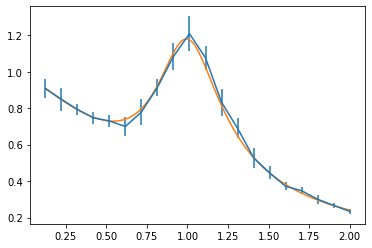

In [3]:
def perceptron_expt(pvals, N, lamb = 0.25, sigma = 0, num_repeats=5):
  errs = np.zeros((len(pvals), num_repeats))
  for i,p in enumerate(pvals):
    key = random.PRNGKey(1)
    for j in range(num_repeats):
      key, teach, train, test, noise = random.split(key, 5)
      w_teach = 1/np.sqrt(N) * random.normal(teach, (N,))
      X_tr = random.normal(train, (p,N))
      X_te = random.normal(test, (5000, N))
      y = X_tr @ w_teach + sigma * random.normal(noise, (p,)) 
      y_true = X_te @ w_teach
      if lamb == 0:
        if p < N:
          yhat = X_te @ X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T) @ y
        else:
          yhat = X_te @ jnp.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y
      else:
        yhat = X_te @ X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T + N*lamb*jnp.eye(p)) @ y

      errs[i,j] = np.mean((yhat - y_true)**2)
  return errs
  

def theory(alpha, sigma, lamb):
  z = 0.5 * ( 1+lamb - alpha + np.sqrt( (1+lamb - alpha)**2 + 4*lamb*alpha ) )
  return (z**2 + sigma**2 * alpha) / ( (alpha+z)**2 - alpha )

In [ ]:
N = 800
num_repeats = 12
sigma = 0.5
lamb = 0.01
pvals = np.linspace(100,2*N,num = 20).astype('int')
errs = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=num_repeats)
ptheory = np.linspace(100, 2*N, num = 1000)
theory_errs = theory(ptheory/N, sigma, lamb)
plt.errorbar(pvals/N, np.mean(errs,axis =1), np.std(errs,axis=1), fmt='o')
plt.plot(ptheory/N, theory_errs)
plt.show()

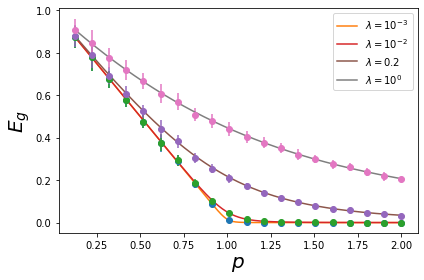

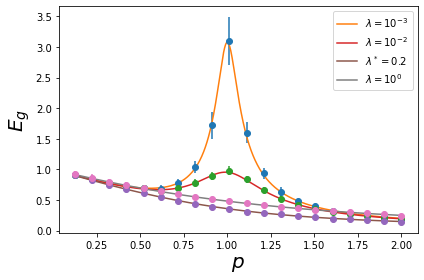

In [8]:
sigma = 0
lamb_vals = [1e-3,1e-2,0.2,1]
ptheory = np.linspace(100, 2*N, num = 1000)
pvals = np.linspace(100,2*N,num = 20).astype('int')

no_noise_expt = []
no_noise_std = []
no_noise_theory = []
for i, lamb in enumerate(lamb_vals):
  expt = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=num_repeats)
  errs = expt.mean(axis=1)
  stds = expt.std(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  no_noise_expt += [errs]
  no_noise_std += [stds]
  no_noise_theory += [theory_errs]

for i, lamb in enumerate(lamb_vals):
  plt.errorbar(pvals/N, no_noise_expt[i], no_noise_std[i], fmt='o')
  if lamb == 0.2:
    plt.plot(ptheory/N, no_noise_theory[i] , label = r'$\lambda = %0.1f$' % lamb )
  else:
    plt.plot(ptheory/N, no_noise_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)) )
plt.legend()
plt.xlabel(r'$p$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.tight_layout()
plt.show()

# make noise nonzero
sigma = np.sqrt(0.2)

reg_noise_expt = []
reg_noise_std = []
reg_noise_theory = []
for i, lamb in enumerate(lamb_vals):
  expt = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=2*num_repeats)
  errs = expt.mean(axis=1)
  stds = expt.std(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  reg_noise_expt += [errs]
  reg_noise_std += [stds]
  reg_noise_theory += [theory_errs]

for i, lamb in enumerate(lamb_vals):
  plt.errorbar(pvals/N, reg_noise_expt[i], reg_noise_std[i], fmt='o')
  if lamb == 0.2:
    plt.plot(ptheory/N, reg_noise_theory[i] , label = r'$\lambda^*  = %0.1f$' % lamb)
  else:
    plt.plot(ptheory/N, reg_noise_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)) )

plt.legend()
plt.xlabel(r'$p$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.tight_layout()
plt.show()

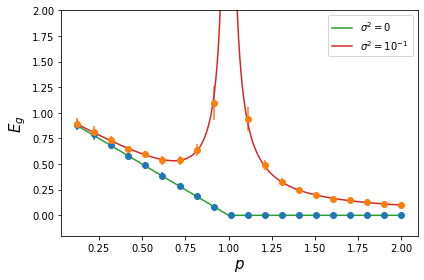

In [9]:
sigmavals = [0,np.sqrt(1e-1)]
lamb = 0
no_reg_expt = []
no_reg_std = []
no_reg_theory = []
for i, sigma in enumerate(sigmavals):
  expt = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=2*num_repeats)
  errs = expt.mean(axis=1)
  stds = expt.std(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  no_reg_expt += [errs]
  no_reg_std += [stds]
  no_reg_theory += [theory_errs]

for i, sigma in enumerate(sigmavals):
  plt.errorbar(pvals/N, no_reg_expt[i], no_reg_std[i], fmt='o')

plt.plot(ptheory/N, no_reg_theory[0] , label = r'$\sigma^2 = 0$')
plt.plot(ptheory/N, no_reg_theory[1] , label = r'$\sigma^2 = 10^{-1}$')

plt.legend()
plt.xlabel(r'$p$', fontsize = 15)
plt.ylabel(r'$E_g$', fontsize = 15)
plt.ylim([-0.2,2])
plt.tight_layout()
plt.show()

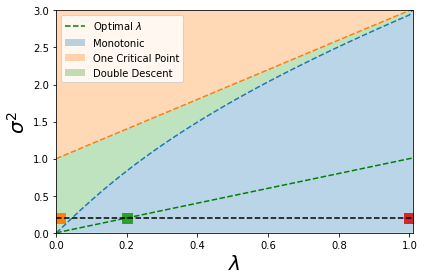

In [10]:
res = 100
lamb_grid = np.linspace(0.0,1.01, res)
sigma2_grid = np.linspace(0,2, res)

def func_boundary(lamb):
  result = []
  for i, l in enumerate(lamb):
    if l <= 1:  
      angle = np.pi/3 + 1/3*np.arctan2( 8*np.sqrt(l)/(9*l*(3*l+2)+1), 1 )
      comp = 3*l*(3*l+2 -2 * np.sqrt(l+1)*np.sqrt(9*l+1) * np.cos(angle))
      result += [comp]
    else:
      result += [2*l + 1]
  return result

plt.plot(lamb_grid, lamb_grid, '--', color = 'green', label = r'Optimal $\lambda$')
plt.plot(lamb_grid, func_boundary(lamb_grid), '--', color = 'C0')
plt.plot(lamb_grid, 2*lamb_grid+1, '--', color = 'C1')
plt.fill_between(lamb_grid, np.zeros(len(lamb_grid)), func_boundary(lamb_grid), alpha = 0.3,  label = 'Monotonic')
plt.fill_between(lamb_grid, 2*lamb_grid+1, 3*np.ones(len(lamb_grid)), alpha = 0.3, label = 'One Critical Point')
plt.fill_between(lamb_grid, func_boundary(lamb_grid), 2*lamb_grid+1, alpha = 0.3, label = 'Double Descent')
plt.scatter([0.001],[0.2], s=100, marker='s', color = 'C0')
plt.scatter([0.01],[0.2], s=100, marker = 's', color = 'C1')
plt.scatter([0.2],[0.2], s=100, marker = 's', color = 'C2')
plt.scatter([1],[0.2], s=100, marker = 's', color = 'C3')
plt.plot(lamb_grid, 0.2*np.ones(len(lamb_grid)) , '--', color = 'black')
plt.legend()
plt.xlabel(r'$\lambda$', fontsize =20)
plt.ylabel(r'$\sigma^2$', fontsize = 20)
plt.xlim([0, np.amax(lamb_grid)])
plt.ylim([0,3])
plt.tight_layout()
plt.show()

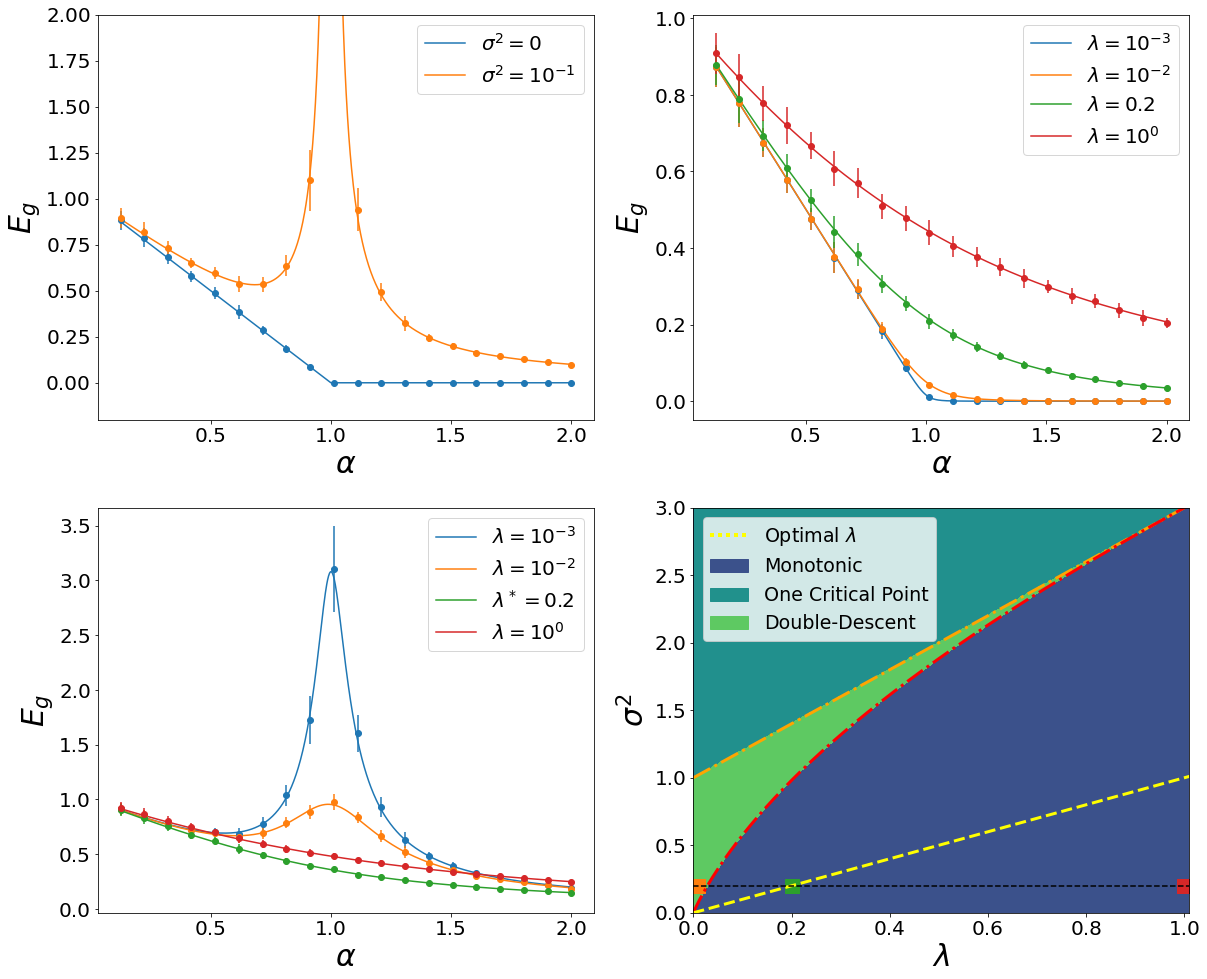

In [16]:
def Noise_tilde(alpha_arr):
    noise_var = np.zeros(len(alpha_arr))
    
    for i, alpha in enumerate(alpha_arr):
        if alpha < 2:
            noise_var[i] = 2*alpha-1
        elif alpha > 2:
            noise_var[i] = ker_sim.noise(alpha)
    return noise_var


plt.rcParams.update({'font.size': 20})
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(17,14))
fontsize = '30'

phase = np.load(dir_phase, allow_pickle = True)
X, Y, Z, levels, alpha, lamb, cut, sigma = [phase['arr_'+str(i)] for i in range(len(phase.files))]


cs=ax4.contourf(X, Y, Z, levels)
ax4.plot(lamb,2*lamb+1,'r-.',color='orange'
         ,linewidth='3')
ax4.plot(lamb[:cut],ker_sim.noise(lamb+1)[:cut],'-.',color='red'
         ,linewidth='3')
ax4.plot(lamb,lamb,'--',color='yellow'
         ,linewidth='3')

ax4.set(xlim=(0, 1.5), ylim=(0, 4))
ax4.set_xlabel("${\\lambda}$",fontsize=fontsize)
ax4.set_ylabel("$\\tilde{\sigma}_{l}^2$",fontsize=fontsize)

ax4.scatter([0.001],[0.2], s=100, marker='s', color = 'C0')
ax4.scatter([0.01],[0.2], s=200, marker = 's', color = 'C1')
ax4.scatter([0.2],[0.2], s=200, marker = 's', color = 'C2')
ax4.scatter([1],[0.2], s=200, marker = 's', color = 'C3')
ax4.plot(lamb_grid, 0.2*np.ones(len(lamb_grid)) , '--', color = 'black')
ax4.set_xlabel(r'$\lambda$', fontsize =fontsize)
ax4.set_ylabel(r'$\sigma^2$', fontsize =fontsize)
ax4.set_xlim([0, np.amax(lamb_grid)])
ax4.set_ylim([0,3])
proxy = [plt.Line2D([0], [0], color='yellow', lw=4, label='Line',dashes=[1,1,1,1])]
pc = [cs.collections[0], cs.collections[2], cs.collections[3]]
for p in pc:
    proxy += [plt.Rectangle((0,0),1,1,color = p.get_facecolor()[0])]

ax4.legend(proxy, ['Optimal $\lambda$', "Monotonic", 
                   "One Critical Point", "Double-Descent"],loc='upper left', bbox_to_anchor=(0.00, 1), fontsize = 19)



colors = ['C0','C1','C2','C3']

for i, sigma in enumerate(sigmavals):
  ax1.errorbar(pvals/N, no_reg_expt[i], no_reg_std[i], fmt='o', color = colors[i])

ax1.plot(ptheory/N, no_reg_theory[0] , label = r'$\sigma^2 = 0$', color = colors[0])
ax1.plot(ptheory/N, no_reg_theory[1] , label = r'$\sigma^2 = 10^{-1}$', color = colors[1])

ax1.legend()
ax1.set_xlabel(r'$\alpha$', fontsize = fontsize)
ax1.set_ylabel(r'$E_g$', fontsize = fontsize)
ax1.set_ylim([-0.2,2])

for i, lamb in enumerate(lamb_vals):
  ax2.errorbar(pvals/N, no_noise_expt[i], no_noise_std[i], fmt='o', color = colors[i])
  if lamb == 0.2:
    ax2.plot(ptheory/N, no_noise_theory[i] , label = r'$\lambda = %0.1f$' % lamb, color = colors[i])
  else:
    ax2.plot(ptheory/N, no_noise_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)), color = colors[i])
ax2.legend()
ax2.set_xlabel(r'$\alpha$', fontsize = fontsize)
ax2.set_ylabel(r'$E_g$', fontsize = fontsize)

for i, lamb in enumerate(lamb_vals):
  ax3.errorbar(pvals/N, reg_noise_expt[i], reg_noise_std[i], fmt='o', color = colors[i])
  if lamb == 0.2:
    ax3.plot(ptheory/N, reg_noise_theory[i] , label = r'$\lambda^*  = %0.1f$' % lamb, color = colors[i])
  else:
    ax3.plot(ptheory/N, reg_noise_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)), color = colors[i])

ax3.legend()
ax3.set_xlabel(r'$\alpha$', fontsize = fontsize)
ax3.set_ylabel(r'$E_g$', fontsize = fontsize)

plt.tight_layout()
if save_data:
  plt.savefig(save_dir + 'Figure3.pdf')

plt.show()